In [1]:
import numpy as np
import pandas as pd
import random

class PricingEnv:
    def __init__(self, df_route):
        """
        Initialize environment for one route's data.
        """
        self.df = df_route.sort_values("time_index").reset_index(drop=True)
        self.current_step = 0
        
        # Define action space (price changes)
        self.actions = [-0.10, -0.05, 0, 0.05, 0.10]
        
        # State columns
        self.state_cols = ["demand_index", "quarter_sin", "quarter_cos", "fare_diff", "large_ms"]
        
    def reset(self):
        """Start new episode"""
        self.current_step = 0
        return self.df.loc[self.current_step, self.state_cols].values
    
    def step(self, action_idx):
        """
        Take an action (adjust price) and return new state, reward, done flag.
        """
        # Get current data
        row = self.df.loc[self.current_step]
        fare = row["fare"]
        passengers = row["passengers"]
        
        # Action = price change %
        action = self.actions[action_idx]
        new_fare = fare * (1 + action)
        
        # Simulate demand change (basic elasticity)
        # if price increases, passengers drop slightly
        elasticity = -0.8  # example elasticity
        new_passengers = passengers * (1 + elasticity * action)
        
        # Reward = Revenue = price * passengers
        reward = new_fare * new_passengers
        
        # Next step
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1
        
        if not done:
            next_state = self.df.loc[self.current_step, self.state_cols].values
        else:
            next_state = np.zeros(len(self.state_cols))
        
        return next_state, reward, done


In [2]:
# Load your processed routes
df = pd.read_csv("processed_routes.csv")

# Pick one route
route_df = df[df["route"] == df["route"].unique()[0]]

env = PricingEnv(route_df)

state = env.reset()
print("Initial state:", state)

for t in range(5):
    action = random.randint(0, 4)
    next_state, reward, done = env.step(action)
    print(f"Step {t+1}: Action={env.actions[action]}, Reward={reward:.3f}")
    if done:
        break


Initial state: [0.863796134 1.0 6.12e-17 0.369741502 0.32]
Step 1: Action=0, Reward=0.101
Step 2: Action=0, Reward=0.075
Step 3: Action=-0.05, Reward=0.080
Step 4: Action=-0.1, Reward=0.081
Step 5: Action=-0.05, Reward=0.068


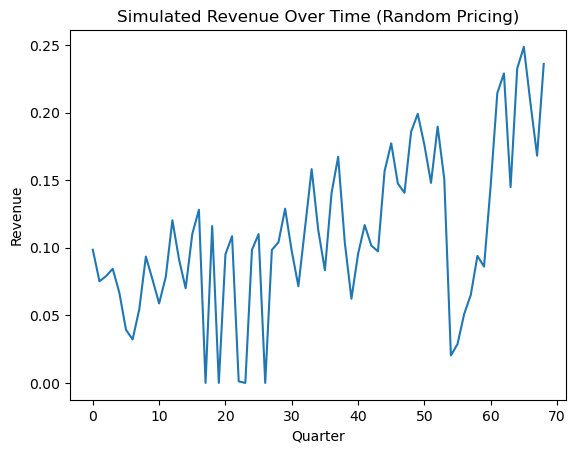

In [3]:
import matplotlib.pyplot as plt

rewards = []
env.reset()
for i in range(len(route_df)-1):
    action = random.randint(0, 4)
    _, reward, done = env.step(action)
    rewards.append(reward)
    if done:
        break

plt.plot(rewards)
plt.title("Simulated Revenue Over Time (Random Pricing)")
plt.xlabel("Quarter")
plt.ylabel("Revenue")
plt.show()
